# Naive Bayes decoder for position decoding based distances to the objects exploration

Here we will use scikit-learn Naive Bayes decoder in order to decode animals positions from calcium neural traces using as labels distance 
from objects that were calculated using DLC tracking inforamation. 

The idea of this decoder is to change the spatial representation to see whether that improbes the performance of the spatial decoder. 


In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy
cmap = cm.jet
import math

In [24]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 56165         ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version


# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 1                 ## value of resampling
session_now = 1
BINS = 70
period = int(1 * sf / re_sf)
period_resting = period *10
fixed = 'None'
## define task for plotting. This will cahnge for other mice!!!!

if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        colapse_behaviour = 1
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        if mouse == 32364:
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   
        if mouse == 56165:
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   

    else:
        if session_now == 2:
            task = 'STABLE'
            colapse_behaviour = 2
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        else:
            task = 'RANDOM'
            colapse_behaviour = 0
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]           
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]

    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32366:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            object_fixed = 6
            colapse_behaviour = 1
            labels =['Unlabel','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]

In [25]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
tracking_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/distance/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/'

In [26]:
# define all relevant files names and load them into a list
session = session_now

activity_list = []
timeline_list = []
behaviour_list = []
tracking_list = []
total_time = 0
day = 0
for trial in [1,6,11,16]:
    
    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_ethogram.npy'
    ## LOAD BEHAVIOUR
    behaviour = np.load(behaviour_dir + beh_file_name_1)
    reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])
    
    ## LOAD TRACKING
    tracking_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75.npy'
    position = np.load(tracking_dir + tracking_file_name_1)
    resample_position, resample_position_stc = stats.resample_matrix(neural_activity=position.T,
                                                                                        re_sf=re_sf)
    ## LOAD TIMELINE
    time_file_session_1 =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_'+ f'{trial}'+'_v1.3.1.0_10.pkl'

    timeline_file= open(timeline_file_dir + time_file_session_1,'rb')
    timeline_info = pickle.load(timeline_file)
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = behaviour.shape[0]
    timeline = timeline_1/re_sf
    time_lenght = 10
    resample_timeline = timeline_1/re_sf
    timeline_list.append(resample_timeline)
    
    behaviour_list.append(resample_beh1)
    tracking_list.append(resample_position)
    total_time = total_time + behaviour.shape[0]
    
    
    file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                          '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                          f'{component_evaluation_v}' +  '.0.npy'

    ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    neural_activity1 = activity[1:,:]
    ## z-score neural activity
    neural_activity = sstats.zscore(neural_activity1)
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                        re_sf=re_sf)
    
    activity_list.append(resample_neural_activity_mean)
    
    day = day + 1

In [27]:
from scipy.ndimage import gaussian_filter

def occupancy_map(tracking = None, binnumber = BINS):
    
    xpos = [int(tracking[0,i]) for i in range(tracking.shape[1])]
    ypos = [int(tracking[1,i]) for i in range(tracking.shape[1])]
    
    occupancy = np.zeros((binnumber,binnumber))
    
    xdenom = int(np.min([np.max(xpos),700])/binnumber+1)
    ydenom = int(np.min([np.max(ypos),700])/binnumber+1)

    data_points = 0
    for x,y in zip(xpos,ypos):
        #print(x)
        if x>=0 and y>=0 and x<700 and y<700 and x!=y:
            x1 = int(x/xdenom)
            y1 = int(y/ydenom)
            occupancy [x1,y1]= occupancy[x1,y1] + 1
            data_points+=1
    occupancy = occupancy/data_points
    return occupancy

def binned_tracking(tracking = None, binnumber = 70):
    
    xpos = [int(tracking[0,i]) for i in range(tracking.shape[1])]
    ypos = [int(tracking[1,i]) for i in range(tracking.shape[1])]
    
    xdenom = int(np.min([np.max(xpos),700])/binnumber+1)
    ydenom = int(np.min([np.max(ypos),700])/binnumber+1)

    data_points = 0
    xnew = []
    ynew = []
    i = 0
    for x,y in zip(xpos,ypos):
        if x>=0 and y>=0 and x<700 and y<700 and x!=y:
            xnew.append(int(xpos[i]/xdenom))
            ynew.append(int(ypos[i]/ydenom))
        i+=1
    
    return xnew,ynew

def neuron_activity_map(activity= None,tracking = None,binnumber = 70, neurinID = 0):
    
    xpos = [int(tracking[0,i]) for i in range(tracking.shape[1])]
    ypos = [int(tracking[1,i]) for i in range(tracking.shape[1])]
    act_map = np.zeros((binnumber,binnumber))
    xdenom = int(np.min([np.max(xpos),700])/binnumber+1)
    ydenom = int(np.min([np.max(ypos),700])/binnumber+1)

    counter = 0
    for x,y in zip(xpos,ypos):
        if x>=0 and y>=0 and x<700 and y<700 and x!=y:
            x1 = int(x/xdenom)
            y1 = int(y/ydenom)
            act_map[x1,y1]+=np.mean(activity[neuronID,counter])
            counter+=1
        
    #act_map = act_map/counter
    return act_map

def mean_activity_map(activity= None,tracking = None,binnumber = BINS):
    
    xpos = [int(tracking[0,i]) for i in range(tracking.shape[1])]
    ypos = [int(tracking[1,i]) for i in range(tracking.shape[1])]
    act_map = np.zeros((binnumber,binnumber))
    xdenom = int(np.min([np.max(xpos),700])/binnumber+1)
    ydenom = int(np.min([np.max(ypos),700])/binnumber+1)

    counter = 0
    for x,y in zip(xpos,ypos):
        if x>=0 and y>=0 and x<700 and y<700 and x!=y:
            x1 = int(x/xdenom)
            y1 = int(y/ydenom)
            act_map[x1,y1]+=np.mean(activity[:,counter])
            counter+=1
        
    act_map = act_map/counter
    return act_map


def speed_selection(tracking = None, speed_limit = 3):
    
    x = tracking[0,:]
    y = tracking[1,:]
    vx = np.diff(x)
    vy = np.diff(y)
    speed = np.sqrt(vx*vx+vy*vy)
    index = np.where(speed > speed_limit)[0]
    
    return index

def poisson_pdf(n,l):
    return pow(l,n)*exp(-l)/math.factorial(n)

(2, 32368)
1890.10581714358


(array([17120.,  2762.,   773.,   592.,   545.,  1422.,  2181.,  3447.,
         2382.,   674.]),
 array([  0.        ,  69.40957588, 138.81915176, 208.22872764,
        277.63830353, 347.04787941, 416.45745529, 485.86703117,
        555.27660705, 624.68618293, 694.09575881]),
 <a list of 10 Patch objects>)

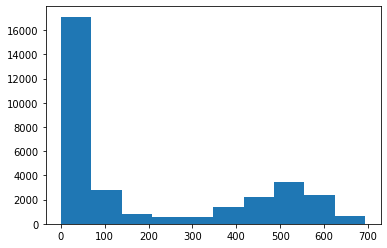

In [28]:
print(tracking_list[0].shape)
#plt.plot(tracking_list[0][0,:])
dist1 = tracking_list[0][0,np.where(tracking_list[0][0,:]<700)[0]]
print(max(tracking_list[0][0,:]))
#occupancy = occupancy_map(tracking_list[0],binnumber = 70)
#plt.plot(dist1)
plt.hist(dist1)


/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


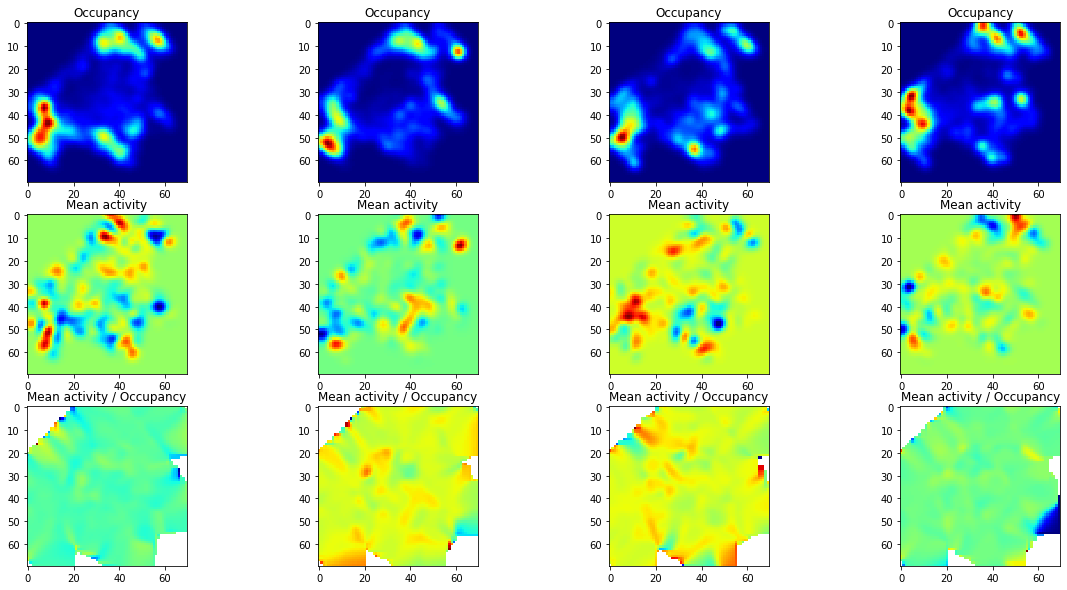

In [29]:
from scipy.ndimage import gaussian_filter
sigma = 2

figure = plt.figure(figsize=(20, 10))
gs = figure.add_gridspec(3, 4)

for day in range(4):
    
    occupancy = occupancy_map(tracking_list[day],binnumber = BINS)
    activity_map_variable = mean_activity_map(activity_list[day],tracking_list[day], binnumber = BINS)
    activity_map_normalized = activity_map_variable/occupancy
    
    occupancy = gaussian_filter(occupancy, sigma)
    activity_map_variable = gaussian_filter(activity_map_variable, sigma)
    #activity_map_normalized = gaussian_filter(activity_map_normalized, sigma)
    
    axes0 = figure.add_subplot(gs[0,day])
    axes1 = figure.add_subplot(gs[1, day])
    axes2 = figure.add_subplot(gs[2, day])

    axes0.imshow(occupancy, cmap = 'jet')
    axes0.set_title('Occupancy')
    axes1.imshow(activity_map_variable, cmap='jet')
    axes1.set_title('Mean activity')
    axes2.imshow(activity_map_variable/occupancy , cmap = 'jet')
    axes2.set_title('Mean activity / Occupancy')

In [30]:
print(occupancy)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.13456890e-12
  5.78824950e-13 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.09100242e-10
  1.24688377e-11 5.78824950e-13]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.22929975e-10
  1.15328635e-10 9.42398137e-12]
 ...
 [4.78133115e-12 6.19829214e-11 7.03867171e-10 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.36015610e-12 1.00980731e-10 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.89412475e-13 1.08589931e-11 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [31]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

ypre = np.array(binned_tracking(tracking = tracking_list[day], binnumber = BINS )).T

binsx = ypre[np.where(np.logical_and(ypre[:,0]<700,ypre[:,0]!=ypre[:,1]))[0],0]
binsy = ypre[np.where(np.logical_and(ypre[:,0]<700,ypre[:,0]!=ypre[:,1]))[0],1]
Xpre = activity_list[day].T
X = Xpre[np.where(np.logical_and(ypre[:,0]<700,ypre[:,0]!=ypre[:,1]))[0],:]
y = [binsx[i]*BINS + binsy[i] for i in range(len(binsx))]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [32]:
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 1538 points : 1061


In [33]:
y_train_x = [int(y_train[i]/BINS) for i in range(len(y_train))]
y_train_y = [y_train[i]%BINS for i in range(len(y_train))]

y_test_x = [int(y_test[i]/BINS) for i in range(len(y_test))]
y_test_y = [y_test[i]%BINS for i in range(len(y_test))]

occupancy_train = occupancy_map(np.array([y_train_x,y_train_y]),binnumber = BINS)
occupancy_train = gaussian_filter(occupancy_train, sigma)

occupancy_test = occupancy_map(np.array([y_test_x,y_test_y]),binnumber = BINS)
occupancy_test = gaussian_filter(occupancy_test, sigma)

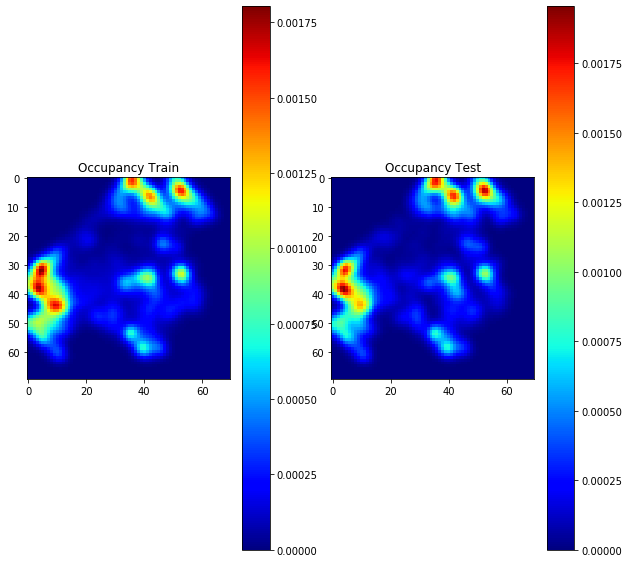

In [34]:
figure = plt.figure(figsize=(10, 10))
gs = figure.add_gridspec(1, 2)
axes0 = figure.add_subplot(gs[0,0])
axes1 = figure.add_subplot(gs[0,1])

pos0 = axes0.imshow(occupancy_train, cmap = 'jet')
axes0.set_title('Occupancy Train')
figure.colorbar(pos0, ax=axes0)
pos1 = axes1.imshow(occupancy_test, cmap = 'jet')
axes1.set_title('Occupancy Test')
figure.colorbar(pos1, ax=axes1)

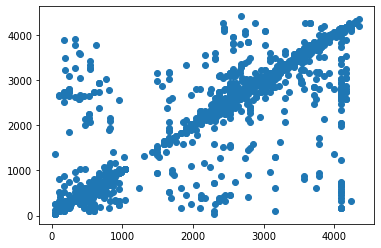

In [35]:
plt.scatter(y_pred,y_test)

In [36]:
y_pred_x = [int(y_pred[i]/BINS) for i in range(len(y_pred))]
y_pred_y = [y_pred[i]%BINS for i in range(len(y_pred))]

y_test_x = [int(y_test[i]/BINS) for i in range(len(y_test))]
y_test_y = [y_test[i]%BINS for i in range(len(y_test))]


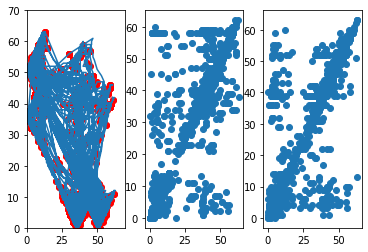

In [37]:
figure , axes = plt.subplots(1,3)
axes[0].plot(ypre[:,0],ypre[:,1])
axes[0].scatter(y_pred_x,y_pred_y,color = 'r')
axes[0].set_xlim([0,BINS])
axes[0].set_ylim([0,BINS])

axes[1].scatter(y_test_x,y_pred_x)

axes[2].scatter(y_test_y,y_pred_y)

In [38]:
from sklearn.metrics import confusion_matrix
confx = confusion_matrix(y_test_x,y_pred_x)
confy = confusion_matrix(y_test_y,y_pred_y)

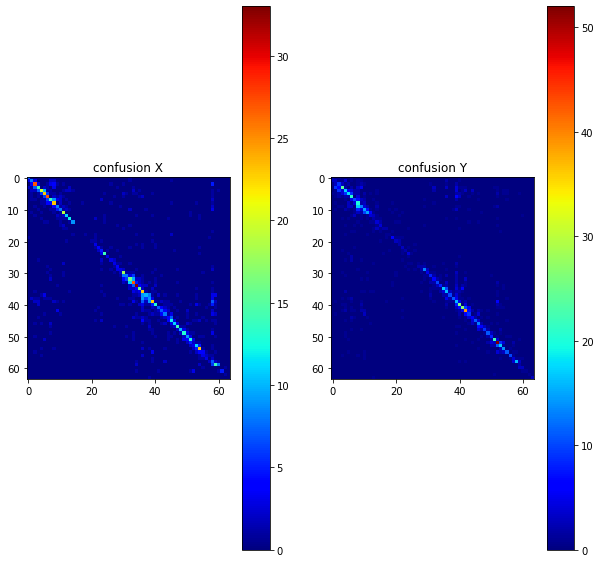

In [39]:
figure = plt.figure(figsize=(10, 10))
gs = figure.add_gridspec(1, 2)
axes0 = figure.add_subplot(gs[0,0])
axes1 = figure.add_subplot(gs[0,1])

#confx = gaussian_filter(confx,sigma)
#confy = gaussian_filter(confy,sigma)

pos0 = axes0.imshow(confx, cmap = 'jet')
axes0.set_title('confusion X')
figure.colorbar(pos0, ax=axes0)
pos1 = axes1.imshow(confy, cmap = 'jet')
axes1.set_title('confusion Y')
figure.colorbar(pos1, ax=axes1)

## Naive bayes in a trial by trail base for distance to object

In [40]:
FR_limit = 10

X = []
y = []
X_shuffle = []
ypre_list = []
for day in range(4):
    for trial in range(5):
        time0 = int(timeline_list[day][trial*2])
        time1 = int(timeline_list[day][trial*2+1])

        tracking_trial = tracking_list[day][:,time0:time1]
        index = speed_selection(tracking_trial, speed_limit = 3)

        tracking = tracking_trial[:,index]
        ypre = np.array(binned_tracking(tracking = tracking, binnumber = BINS )).T
        ypre_list.append(ypre)
        binsx = ypre[np.where(np.logical_and(ypre[:,0]>0,ypre[:,1]>0))[0],0]
        binsy = ypre[np.where(np.logical_and(ypre[:,0]>0,ypre[:,1]>0))[0],1]

        Xpre = activity_list[day][:,time0:time1].T
        Xpre = Xpre[np.where(np.logical_and(ypre[:,0]>0,ypre[:,1]>0))[0],:]
        firing_rate = np.mean(Xpre,axis = 0)*10
        selected_cells = np.where(firing_rate < FR_limit)[0]
        X_decode = Xpre[:,selected_cells]
        X.append(X_decode.copy())
        np.random.shuffle(X_decode)
        X_shuffle.append(X_decode)
        y.append([binsx[i]*BINS + binsy[i] for i in range(len(binsx))])

In [41]:
print(type(X_shuffle[0]))
y_test_list = []
y_pred_list = []
y_pred_list_shuffle = []
y_test_list_shuffle = []

for trial in range(5*4): 
    X_train, X_test, y_train, y_test = train_test_split(X[trial], y[trial], test_size=0.1, random_state=0)
    X_train_shuffle , X_test_shuffle , y_train_shuffle, y_test_shuffle = train_test_split(X_shuffle[trial], y[trial], test_size=0.1, random_state=0)
    gnb = GaussianNB()
    y_pred = gnb.fit(X_train, y_train).predict(X_test)
    y_test_list.append(y_test)
    y_pred_list.append(y_pred)
    
    y_pred_shuffle = gnb.fit(X_train_shuffle, y_train_shuffle).predict(X_test_shuffle)
    y_test_list_shuffle.append(y_test_shuffle)
    y_pred_list_shuffle.append(y_pred_shuffle)
    print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

<class 'numpy.ndarray'>
Number of mislabeled points out of a total 195 points : 178
Number of mislabeled points out of a total 126 points : 103
Number of mislabeled points out of a total 172 points : 156
Number of mislabeled points out of a total 172 points : 150
Number of mislabeled points out of a total 192 points : 165
Number of mislabeled points out of a total 151 points : 137
Number of mislabeled points out of a total 107 points : 93
Number of mislabeled points out of a total 87 points : 75
Number of mislabeled points out of a total 98 points : 81
Number of mislabeled points out of a total 107 points : 103
Number of mislabeled points out of a total 101 points : 91
Number of mislabeled points out of a total 163 points : 141
Number of mislabeled points out of a total 149 points : 127
Number of mislabeled points out of a total 124 points : 105
Number of mislabeled points out of a total 60 points : 52
Number of mislabeled points out of a total 123 points : 102
Number of mislabeled poi

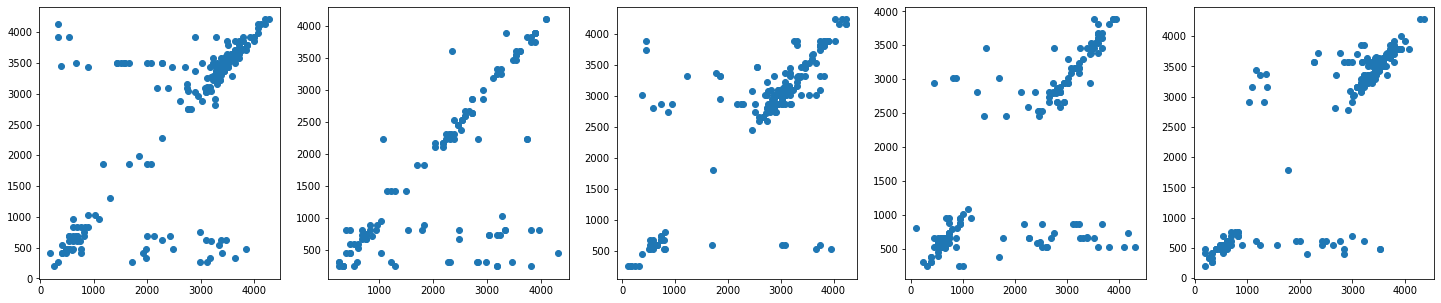

In [42]:
figure, axes = plt.subplots(1,5)
for trial in range(5):
    axes[trial].scatter(y_test_list[trial],y_pred_list[trial])
figure.set_size_inches(25,5)

MeanError: 11.777168040903934 Std: 17.78665172546474
MeanErrorProp: 0.16824525772719906 PRopStd: 0.2540950246494963
MeanError: 10.327967069015594 Std: 15.56552206556884
MeanErrorProp: 0.14754238670022277 PRopStd: 0.22236460093669771
MeanError: 9.448423446632496 Std: 13.938839545008667
MeanErrorProp: 0.13497747780903566 PRopStd: 0.19912627921440954
MeanError: 9.006493627305451 Std: 14.021969572097966
MeanErrorProp: 0.12866419467579215 PRopStd: 0.20031385102997093
MeanError: 8.362822135973973 Std: 13.789174410459232
MeanErrorProp: 0.11946888765677104 PRopStd: 0.1969882058637033


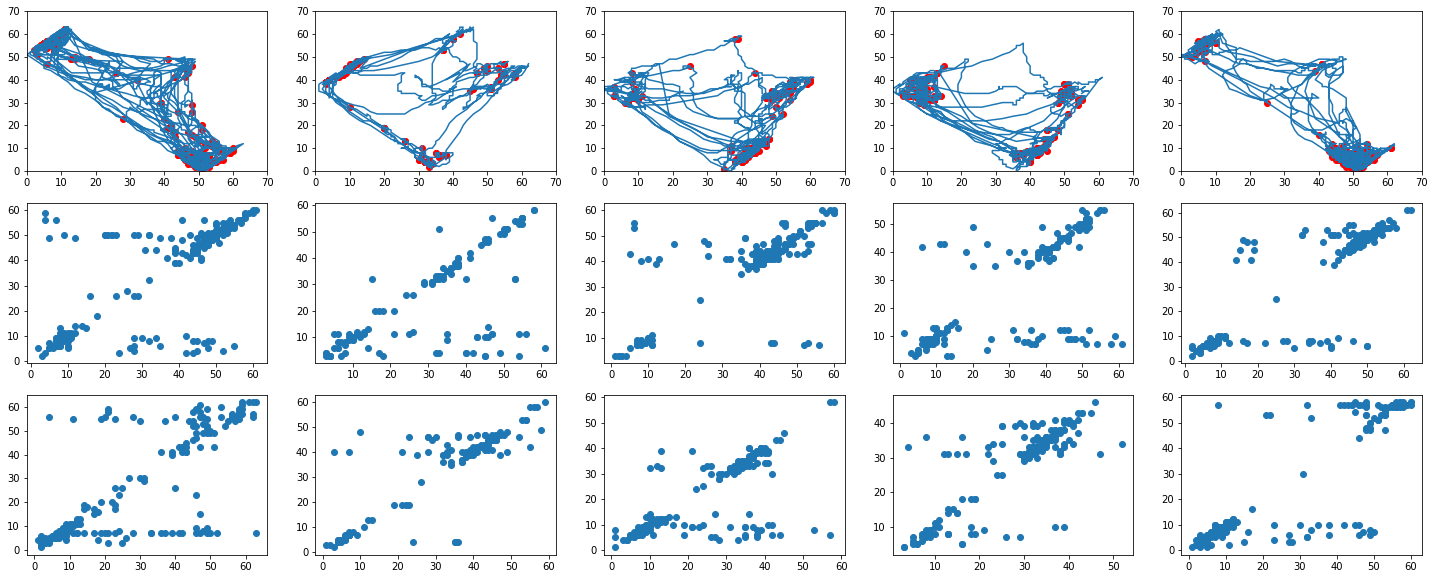

In [43]:
figure , axes = plt.subplots(3,5)

for trial in range(5):
    
    y_pred = y_pred_list[trial]
    y_test = y_test_list[trial]
    
    y_pred_x = [int(y_pred[i]/BINS) for i in range(len(y_pred))]
    y_pred_y = [y_pred[i]%BINS for i in range(len(y_pred))]

    y_test_x = [int(y_test[i]/BINS) for i in range(len(y_test))]
    y_test_y = [y_test[i]%BINS for i in range(len(y_test))]

    x_dist = np.array([ y_pred_x[i] - y_test_x[i] for i in range(len(y_pred_x))])
    y_dist = np.array([ y_pred_y[i] - y_test_y[i] for i in range(len(y_pred_x))])
     
    distance = np.sqrt((x_dist)*(x_dist)+(y_dist)*(y_dist))
    print('MeanError: ' + str(np.mean(distance)) + ' Std: ' + str(np.std(distance)))
    print('MeanErrorProp: ' + str(np.mean(distance)/BINS) + ' PRopStd: ' + str(np.std(distance)/BINS))
    
    axes[0,trial].plot(ypre_list[trial][:,0],ypre_list[trial][:,1])
    axes[0,trial].scatter(y_pred_x,y_pred_y,color = 'r')
    axes[0,trial].set_xlim([0,BINS])
    axes[0,trial].set_ylim([0,BINS])

    axes[1,trial].scatter(y_test_x,y_pred_x)

    axes[2,trial].scatter(y_test_y,y_pred_y)
    figure.set_size_inches(25,10)


In [44]:
distance_trial = []
distance_trial_shuffle = []

for trial in range(5*4):
    
    y_pred = y_pred_list[trial]
    y_test = y_test_list[trial]
    
    y_pred_x = [int(y_pred[i]/BINS) for i in range(len(y_pred))]
    y_pred_y = [y_pred[i]%BINS for i in range(len(y_pred))]

    y_test_x = [int(y_test[i]/BINS) for i in range(len(y_test))]
    y_test_y = [y_test[i]%BINS for i in range(len(y_test))]

    x_dist = np.array([ y_pred_x[i] - y_test_x[i] for i in range(len(y_pred_x))])
    y_dist = np.array([ y_pred_y[i] - y_test_y[i] for i in range(len(y_pred_x))])
    distance = np.sqrt((x_dist)*(x_dist)+(y_dist)*(y_dist))
    distance_trial.append(np.mean(distance))
    
        
    y_pred = y_pred_list_shuffle[trial]
    y_test = y_test_list_shuffle[trial]
    
    y_pred_x = [int(y_pred[i]/BINS) for i in range(len(y_pred))]
    y_pred_y = [y_pred[i]%BINS for i in range(len(y_pred))]

    y_test_x = [int(y_test[i]/BINS) for i in range(len(y_test))]
    y_test_y = [y_test[i]%BINS for i in range(len(y_test))]

    x_dist = np.array([ y_pred_x[i] - y_test_x[i] for i in range(len(y_pred_x))])
    y_dist = np.array([ y_pred_y[i] - y_test_y[i] for i in range(len(y_pred_x))])
    distance = np.sqrt((x_dist)*(x_dist)+(y_dist)*(y_dist))
    distance_trial_shuffle.append(np.mean(distance))
    


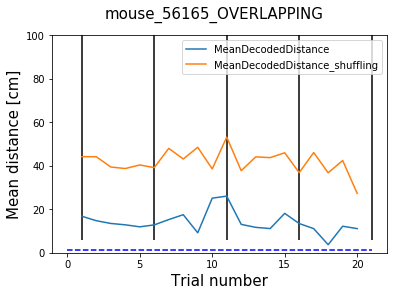

In [45]:
figure, axes = plt.subplots(1)

axes.plot(np.arange(1,len(distance_trial)+1),np.array(distance_trial)*100/BINS)#,np.array(distance_trial_std)*100/BINS)
axes.plot(np.arange(1,len(distance_trial_shuffle)+1),np.array(distance_trial_shuffle)*100/BINS)#,np.array(distance_trial_shuffle)*100/BINS)
axes.legend(['MeanDecodedDistance','MeanDecodedDistance_shuffling'])
axes.set_xlabel('Trial number', fontsize = 15)
axes.set_ylabel('Mean distance [cm]', fontsize = 15)
axes.set_ylim([0,100])

plt.vlines(1, 6, 100, colors='k', linestyles='-')
plt.vlines(6, 6, 100, colors='k', linestyles='-')
plt.vlines(11, 6, 100, colors='k', linestyles='-')
plt.vlines(16, 6, 100, colors='k', linestyles='-')
plt.vlines(21, 6, 100, colors='k', linestyles='-')
plt.hlines((700/BINS)/7, 0, 21, colors='b', linestyles='--') 

figure.suptitle('mouse_' + f'{mouse}' + '_' + task , fontsize = 15)

figure_name = 'distance_postion_decoder_naive_bayes_'+'mouse_' + f'{mouse}' + '_' + task +'_BINS_'+f'{BINS}' +'.png'
figure.savefig(figure_path + figure_name)